
### Copyright and License

© 2026, Isabel Bejerano Blazquez

This Jupyter Notebook is licensed under the **MIT License**. 

**Disclaimer:**

- The notebook is provided "as is", without warranty of any kind. The author is not liable for any claims or damages arising from the use of this notebook.

**Dataset Note:**

- The analyses are based on the SPARCS Hospital Inpatient Discharges dataset 
(NYC, Richmond County, 2023), licensed under the **Open Database License (ODbL)**



# Predictive Pipeline: 'Length of Stay' Regression and 'Discharge' Classification

**Dataset:** [SPARCS Hospital Inpatient Discharges – New York City (Richmond County, 2023)](https://healthdata.gov/dataset/Hospital-Inpatient-Discharges-SPARCS-De-Identified/tpup-hey9/data_preview)

Locally stored under ../datasets

License: Open Database License (ODbL)


## Abstract

Administrative healthcare datasets are increasingly used in health services 
research to study utilization patterns, cost structures, and outcome proxies in 
the absence of detailed clinical variables.

This notebook presents a comprehensive, reproducible, and academically grounded
data analysis pipeline applied to the SPARCS inpatient discharge dataset for Richmond County (NYC, 2023).

This notebook presents a reproducible predictive modeling pipeline applied
to administrative inpatient discharge data from the SPARCS database. The analysis emphasizes data quality assessment, feature engineering, and supervised learning models to predict hospital length of stay (LOS) and classification of patient discharge. Model performance is evaluated using out-of-sample metrics, and model
interpretability is discussed in the context of healthcare operations.

Results are interpreted under an associational framework, acknowledging the
observational and administrative nature of the data.


### Dataset Relevance

The SPARCS inpatient discharge dataset provides comprehensive, population-level 
coverage of hospitalizations in New York State through mandatory reporting by 
acute care hospitals. Its standardized structure and large sample size make it 
well suited for observational health services research focused on utilization 
and system-level outcomes.

Although administrative data lack detailed clinical measures, they offer strong 
external validity for studying inpatient care patterns, costs, and operational 
metrics. The Richmond County subset reflects care delivery in a dense urban 
setting and is therefore appropriate for analyzing hospital utilization dynamics. 
The dataset is fully de-identified and licensed under the Open Database License 
(ODbL), ensuring ethical compliance and reproducibility.

### Relevance of Hospital Length of Stay (LOS)

Length of Stay (LOS) is a core outcome in inpatient healthcare research, 
reflecting both clinical complexity and hospital operational efficiency. 
Prolonged LOS is commonly associated with increased resource utilization, higher 
costs, and challenges in discharge planning.

In administrative datasets such as SPARCS, LOS is particularly valuable because 
it is consistently recorded, minimally affected by coding discretion, and 
available for all hospitalizations. As a result, LOS serves as a reliable proxy 
outcome when detailed measures of disease severity are unavailable and is widely 
used in health services and policy research.

## 1. Analytical framework and research design

This study follows a quantitative, observational, cross-sectional design using administrative hospital discharge data. The primary objective is to construct a reproducible data preprocessing, feature curation, and exploratory modeling pipeline suitable for predicting hospital length of stay (LOS) using variables available at or near the time of admission.

The analysis is explicitly associational and predictive, not causal. No attempt is made to estimate structural relationships or causal effects between patient characteristics and outcomes. Model outputs, correlations, and coefficients are interpreted descriptively and heuristically, with the goal of understanding predictive signal rather than inference.

1. Data ingestion and structural inspection
2. Data quality diagnostics
3. Cleaning and transformation
4. Target leakage prevention and feature curation
5. Feature engineering and encoding
6. Exploratory data analysis (EDA)
7. Predictive modeling
8. Hypothesis formulation and contrast
9. Interpretation and limitations

Although linear regression models are employed, the primary objective of this study is prediction rather than causal or explanatory inference. The analysis aims to assess how well routinely collected administrative variables can predict hospital length of stay, rather than to estimate structural relationships or causal effects.

### Temporal availability of variables and leakage control

Administrative hospital discharge data contain variables that become available at different points in the care trajectory. For predictive modeling of 'length of stay' at the time of admission, it is necessary to distinguish between:

- Admission-time variables (e.g., demographics, admission type, diagnosis group, severity indices)
- Post-admission or discharge-time variables (e.g., total charges, total costs, discharge disposition, procedure codes)
- Variables that may be partially informed at admission but their finalized values depend on post-admission coding (e.g., APR related variables)

Variables in the second and third categories are not available at the time a 'length of stay' prediction would be generated and therefore constitute potential sources of target leakage.

## 2. Data source and ethical considerations

The analysis uses the SPARCS Hospital Inpatient Discharges dataset for Richmond County (New York City), 2023, provided by the New York State Department of Health. The dataset contains fully de-identified, patient-level administrative discharge records and is licensed under the Open Database License (ODbL).

Ethical considerations include:

- No direct personal identifiers are present
- No attempt is made to re-identify individuals
- All analyses are conducted on de-identified administrative records

All derived tables, figures, and outputs constitute Produced Works under the ODbL.

## 3. Dataset loading and verification

In [1]:
import csv
import pandas as pd
filename = '../datasets/Hospital_Inpatient_Discharges_SPARCS_De-Identified_NYCity_Richmond_2023.csv'

df = pd.read_csv(
    filename,
    sep=';',                    # semicolon delimiter
    quotechar='"',              # double quotes around fields
    quoting=csv.QUOTE_MINIMAL,  # only quote fields that need it
    engine='python',            # more robust than C engine
    skipinitialspace=True       # ignore spaces after ;
)

# (rows, columns)
print(f"Shape: {df.shape}")
# Convert columns to a list
print(df.columns.tolist())


Shape: (52058, 33)
['Hospital Service Area', 'Hospital County', 'Operating Certificate Number', 'Permanent Facility Id', 'Facility Name', 'Age Group', 'Zip Code - 3 digits', 'Gender', 'Race', 'Ethnicity', 'Length of Stay', 'Type of Admission', 'Patient Disposition', 'Discharge Year', 'CCSR Diagnosis Code', 'CCSR Diagnosis Description', 'CCSR Procedure Code', 'CCSR Procedure Description', 'APR DRG Code', 'APR DRG Description', 'APR MDC Code', 'APR MDC Description', 'APR Severity of Illness Code', 'APR Severity of Illness Description', 'APR Risk of Mortality', 'APR Medical Surgical Description', 'Payment Typology 1', 'Payment Typology 2', 'Payment Typology 3', 'Birth Weight', 'Emergency Department Indicator', 'Total Charges', 'Total Costs']


In [2]:
# Show 5 first rows
df.head()


,Hospital Service Area,Hospital County,Operating Certificate Number,Permanent Facility Id,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,...,APR Severity of Illness Description,APR Risk of Mortality,APR Medical Surgical Description,Payment Typology 1,Payment Typology 2,Payment Typology 3,Birth Weight,Emergency Department Indicator,Total Charges,Total Costs
0,New York City,Richmond,7004003,1740,Staten Island University Hosp-North,50 to 69,103,M,White,Not Span/Hispanic,...,Minor,Moderate,Surgical,Medicare,Medicare,NaN,NaN,Y,"93,566.39","20,583.31"
1,New York City,Richmond,7004003,1740,Staten Island University Hosp-North,50 to 69,103,F,Other Race,Not Span/Hispanic,...,Moderate,Major,Medical,Medicare,Medicare,Medicaid,NaN,Y,"51,564.46","11,652.85"
2,New York City,Richmond,7004003,1740,Staten Island University Hosp-North,70 or Older,103,M,White,Not Span/Hispanic,...,Moderate,Major,Medical,Medicare,Medicare,NaN,NaN,Y,"37,003.20","9,256.67"
3,New York City,Richmond,7004003,1740,Staten Island University Hosp-North,50 to 69,103,M,Black/African American,Not Span/Hispanic,...,Moderate,Minor,Medical,Miscellaneous/Other,Private Health Insurance,NaN,NaN,Y,"47,013.41","12,210.79"
4,New York City,Richmond,7004003,1740,Staten Island University Hosp-North,70 or Older,103,M,White,Not Span/Hispanic,...,Extreme,Extreme,Medical,Medicare,Blue Cross/Blue Shield,NaN,NaN,Y,"38,319.00","8,827.74"


### Dataset Summary and Key Observations

The dataset was loaded from a locally stored CSV file using a semicolon delimiter and Python-based parsing to ensure robustness against malformed rows and embedded delimiters. Initial inspection verified:

- Dataset dimensions (52,058 hospitalizations × 33 variables)
- One row per hospital discharge
- Consistent column encoding and absence of structural corruption

Column names, data types, and sample records were examined to confirm alignment with SPARCS documentation.

Preliminary inspection reveals:

- **Demographics:** The majority of patients fall within the 50–69 age range, 
with representation across gender and racial categories typical of the urban 
Richmond County population.  
- **Clinical Complexity:** APR severity of illness and risk of mortality codes 
indicate a spectrum from minor to extreme clinical complexity, suitable for 
associational analyses with outcomes such as length of stay (LOS) and cost.  
- **Financial Measures:** Total charges and costs exhibit right-skewed 
distributions, consistent with heavy-tailed hospital expenditure patterns. 
Log-transformations and robust preprocessing are therefore appropriate for 
predictive modeling.  
- **Administrative Consistency:** All hospital identifiers, payment typologies, 
and procedure/diagnosis codes are systematically encoded, allowing reproducible 
cross-sectional analysis and alignment with prior health services research.


## 4. Structural and metadata inspection

In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52058 entries, 0 to 52057
Data columns (total 33 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   Hospital Service Area                52058 non-null  object
 1   Hospital County                      52058 non-null  object
 2   Operating Certificate Number         52058 non-null  int64 
 3   Permanent Facility Id                52058 non-null  int64 
 4   Facility Name                        52058 non-null  object
 5   Age Group                            52058 non-null  object
 6   Zip Code - 3 digits                  51581 non-null  object
 7   Gender                               52058 non-null  object
 8   Race                                 52058 non-null  object
 9   Ethnicity                            52058 non-null  object
 10  Length of Stay                       52058 non-null  object
 11  Type of Admission                    5205

In [4]:
import numpy as np
import pandas as pd

# Numeric summary (column-wise)
print("Numeric summary")

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

numeric_summary = pd.DataFrame({
    "count": df[numeric_cols].count(),
    "missing": df[numeric_cols].isna().sum(),
    "missing_%": (df[numeric_cols].isna().mean() * 100).round(2),
    "mean": df[numeric_cols].mean(),
    "std": df[numeric_cols].std(),
    "min": df[numeric_cols].min(),
    "max": df[numeric_cols].max(),
    "unique": df[numeric_cols].nunique()
}).sort_values("missing_%", ascending=False)

print(numeric_summary)

Numeric summary
                              count  missing  missing_%          mean  \
Operating Certificate Number  52058        0        0.0  7.004005e+06   
Permanent Facility Id         52058        0        0.0  1.739053e+03   
Discharge Year                52058        0        0.0  2.023000e+03   
APR DRG Code                  52058        0        0.0  4.056524e+02   
APR MDC Code                  52058        0        0.0  1.003623e+01   
APR Severity of Illness Code  52058        0        0.0  2.015483e+00   

                                     std      min      max  unique  
Operating Certificate Number    3.076179  7004003  7004010       2  
Permanent Facility Id           1.192134     1737     1740       3  
Discharge Year                  0.000000     2023     2023       1  
APR DRG Code                  240.362927        4      956     314  
APR MDC Code                    5.874633        0       25      26  
APR Severity of Illness Code    0.958596        0        4

In [5]:
# Categorical summary (column-wise)
print("\nCategorical summary")

categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

cat_summary = pd.DataFrame({
    "count": df[categorical_cols].count(),
    "missing": df[categorical_cols].isna().sum(),
    "missing_%": (df[categorical_cols].isna().mean() * 100).round(2),
    "unique": df[categorical_cols].nunique(),
    "top_value": df[categorical_cols].mode().iloc[0],
    "top_freq": df[categorical_cols].apply(lambda x: x.value_counts().iloc[0])
}).sort_values("missing_%", ascending=False)

print(cat_summary)


Categorical summary
                                     count  missing  missing_%  unique  \
Birth Weight                          5373    46685      89.68      48   
Payment Typology 3                   22211    29847      57.33       8   
Payment Typology 2                   30218    21840      41.95       8   
CCSR Procedure Description           34423    17635      33.88     281   
CCSR Procedure Code                  34423    17635      33.88     281   
Zip Code - 3 digits                  51581      477       0.92      22   
APR Severity of Illness Description  52042       16       0.03       4   
APR Risk of Mortality                52042       16       0.03       4   
Facility Name                        52058        0       0.00       3   
Hospital County                      52058        0       0.00       1   
Hospital Service Area                52058        0       0.00       1   
Patient Disposition                  52058        0       0.00      16   
Type of Admission

### Structural Inspection

A full structural inspection (df.info() and descriptive summaries) was performed to classify variables by measurement scale:

- Categorical variables: demographics, admission type, diagnosis descriptors, payment typologies
- Ordinal variables: age group categories
- Numeric identifiers: facility and certificate identifiers
- Outcome variable: length of stay (LOS), initially stored as a string


## 5. Target Leakage Prevention

To simulate a realistic admission-time prediction setting, variables not plausibly available at admission were excluded prior to any feature engineering or screening.

**Hard Leakage Variables (Dropped)**: Variables determined at or after discharge were removed entirely:

- Patient Disposition
- Total Charges
- Total Costs
- Payment Typology 2
- Payment Typology 3

These variables directly encode downstream outcomes and would invalidate predictive evaluation if retained.

**Soft Leakage Variables (Dropped)**: Several clinically derived classification variables were excluded as conservative sources of soft leakage, including:

- CCSR Procedure Code and Description
- APR DRG Code and Description
- APR MDC Code and Description
- APR Severity of Illness (code and description)
- APR Risk of Mortality

Although some of these variables may be partially informed at admission, their finalized values depend on post-admission coding and are explicitly designed to explain outcomes such as LOS. Excluding them avoids reliance on downstream administrative summaries.

In [6]:
# hard leakage: never available at admission
hard_leakage_cols = [
    "Patient Disposition",
    "Total Charges",
    "Total Costs",
    "Payment Typology 2",
    "Payment Typology 3"
]

df = df.drop(
    columns=[c for c in hard_leakage_cols if c in df.columns],
    errors="ignore"
)

# soft leakage: typically determined after admission (conservative choice)
soft_leakage_cols = [
    "CCSR Procedure Code",
    "CCSR Procedure Description",
    "APR DRG Code",
    "APR DRG Description",
    "APR Medical Surgical Description", 
    "APR MDC Code",
    "APR MDC Description", 
    "APR Risk of Mortality",
    "APR Severity of Illness Code",
    "APR Severity of Illness Description"
]

df = df.drop(
    columns=[c for c in soft_leakage_cols if c in df.columns],
    errors="ignore"
)

### 6. Data quality assessment

In [7]:
# Compute the proportion of missing values (NaN) per column
na_summary = df.isna().mean().sort_values(ascending=False)
na_summary[na_summary > 0]


Birth Weight           0.896788
Zip Code - 3 digits    0.009163
dtype: float64

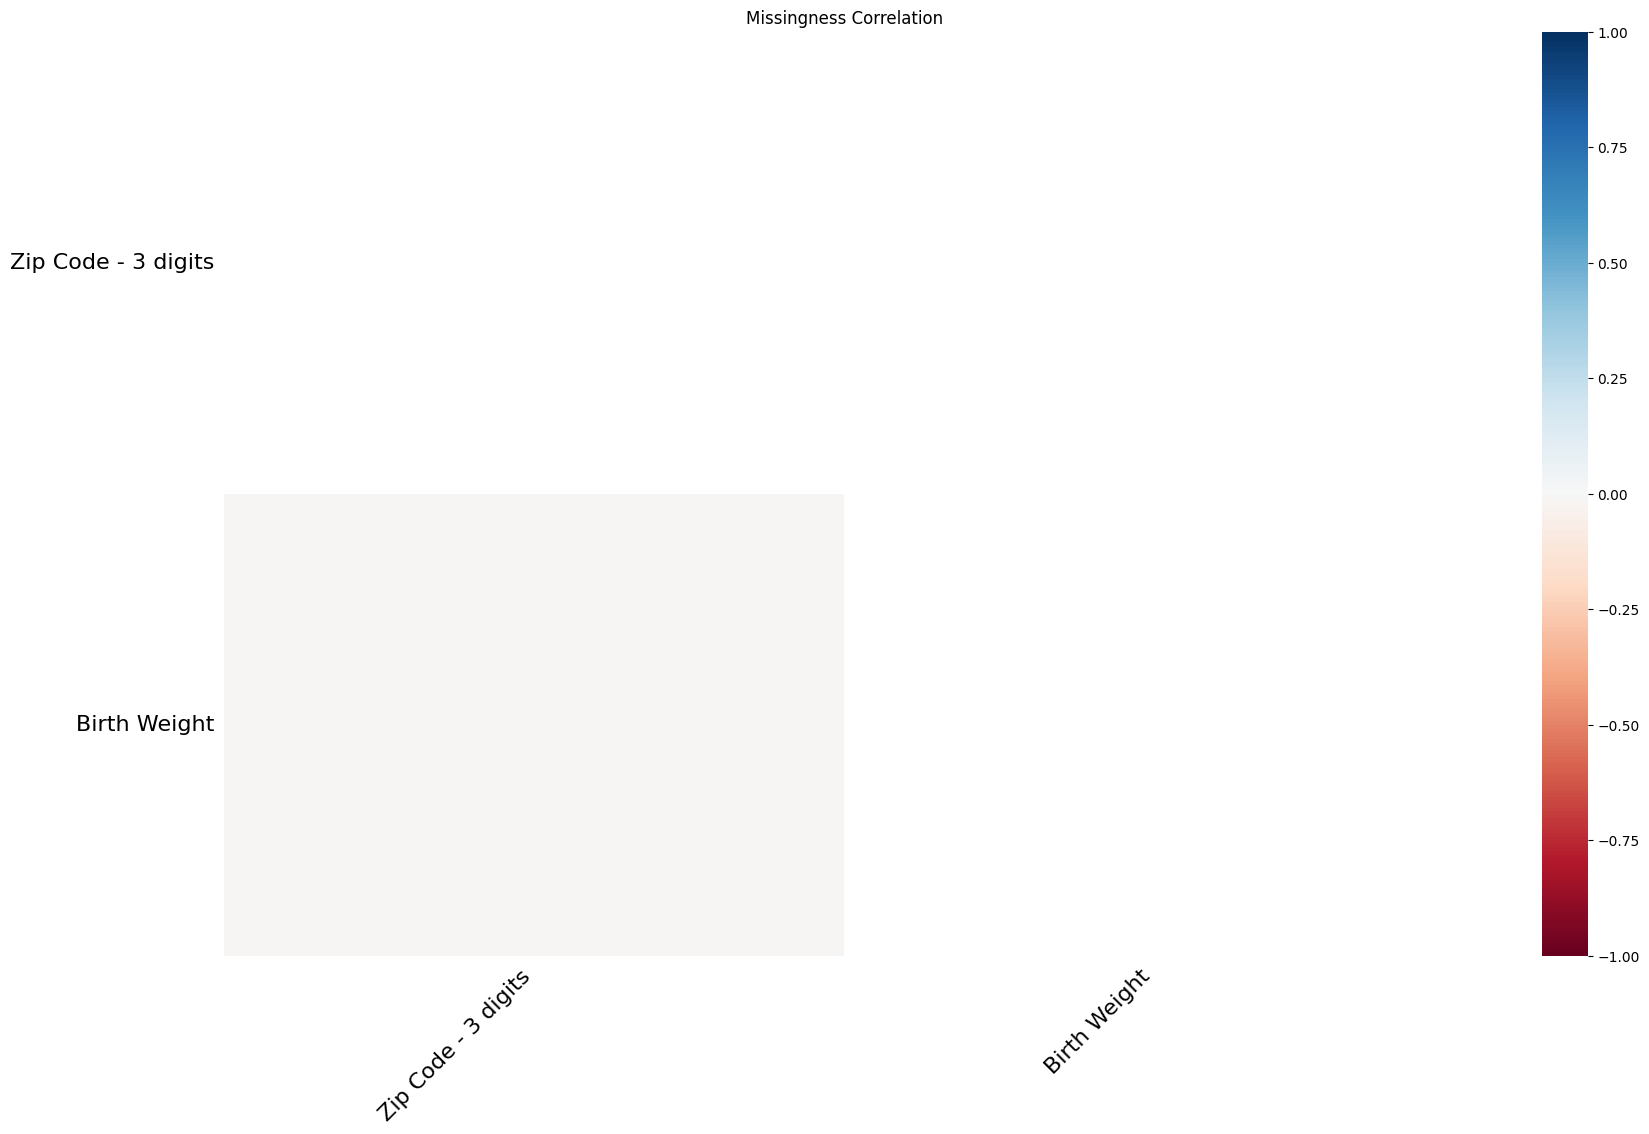

Top missing correlations:
 Birth Weight           Birth Weight                    1.000000
Zip Code - 3 digits    Birth Weight                    0.011774
Birth Weight           Zip Code - 3 digits             0.011774
Hospital Service Area  Hospital Service Area                NaN
                       Hospital County                      NaN
                       Operating Certificate Number         NaN
                       Permanent Facility Id                NaN
                       Facility Name                        NaN
                       Age Group                            NaN
dtype: float64


In [8]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt

# Missingness correlation heatmap (MAR patterns)
msno.heatmap(df)
plt.title("Missingness Correlation")
plt.show()

# MCAR proxy: correlation of missingness indicators
missing_ind = df.isna().astype(int)
corr_matrix = (
    missing_ind.corr().abs()
    .unstack()
    .sort_values(ascending=False)
)

print("Top missing correlations:\n", corr_matrix[1:10])

### Missing Data Diagnostics

Missingness assessment distinguishes MCAR (random), MAR (predictable from observed), and MNAR (predictable from missing values). Here we use pairwise chi-squared tests on missing indicators, significant associations (p<0.05) suggest MAR, informing imputation or deletion strategy.


In [9]:
import pandas as pd
from scipy.stats import chi2_contingency

def simple_mcar_check(df, alpha=0.05):
    """Bivariate chi2 on missing indicators (MCAR proxy)."""
    miss_ind = pd.DataFrame(df.isnull().astype(int))
    miss_cols = miss_ind.columns[miss_ind.sum() > 0]  # Vars with missing
    
    sig_pairs = []
    for i, col1 in enumerate(miss_cols):
        for col2 in miss_cols[i+1:]:
            table = pd.crosstab(miss_ind[col1], miss_ind[col2])
            if table.shape[0] > 1 and table.shape[1] > 1:
                chi2, p, dof, exp = chi2_contingency(table)
                if p < alpha:
                    sig_pairs.append((col1, col2, p))
    
    if sig_pairs:
        print("Potential MAR pairs (p<0.05):")
        for pair in sig_pairs[:5]:
            print(f"  {pair[0]} vs {pair[1]}: p={pair[2]:.3f}")
    else:
        print("No significant MAR patterns detected (chi2 p>=0.05)")
    print(f"Checked {len(miss_cols)} vars with missing data")
    return sig_pairs

simple_results = simple_mcar_check(df)


Potential MAR pairs (p<0.05):
  Zip Code - 3 digits vs Birth Weight: p=0.009
Checked 2 vars with missing data


Missingness was quantified at the column level. Two variables exhibited non-trivial missingness:
- Birth Weight (~89.7% missing), reflecting clinical inapplicability outside neonatal cases
- Zip Code (3-digit) (<1% missing), negligible for analysis

A bivariate chi-squared analysis of missingness indicators was conducted as a proxy diagnostic for MCAR versus MAR mechanisms. The observed dependence between Birth Weight and Zip Code missingness is consistent with administrative reporting practices and does not indicate systematic bias relevant to LOS modeling.

Given the administrative nature of the data and the limited scope of missingness, no imputation was performed. Variables with extreme missingness were excluded during feature curation.

## 7. Data cleaning strategy

### Feature Curation

Balance methodological rigor with predictive utility through conservative feature retention, pruning only extreme informational voids while preserving admission-time clinical relevance.

Based on the previous missing data diagnostics, columns with no variance or trivial variability (e.g., hospital county, discharge year) were removed.

In [10]:
# Create a clean copy of the DataFrame,
df_clean = df.copy()
# drop fully empty columns
df_clean = df_clean.dropna(axis=1, how='all')

# Dynamic MAR and constants removal
# Reuse MAR analysis
mar_problem_pairs = simple_results  # chi2 results

problem_features = set()
for col1, col2, p in mar_problem_pairs:
    problem_features.add(col1)
    problem_features.add(col2)

print(f"MCAR detected problematic features: {list(problem_features)}")
print(f"   Chi2 evidence: {mar_problem_pairs[0][2]:.3f} p-value")

# Constant detection
constants_detected = df_clean.columns[df_clean.nunique() <= 1].tolist()
constants_to_remove = [
    c for c in constants_detected if c != 'Length of Stay']
print(f"Constants detected (nunique <= 1) ({
    len(constants_to_remove)}): {constants_to_remove[:4]}...")

# Removal
all_drop_features = list(set(list(problem_features) + constants_to_remove))
dropped_features = [c for c in all_drop_features if c in df_clean.columns]

df_clean = df_clean.drop(columns=dropped_features, errors='ignore')

print(f"\nPre-cleaning shape: {df.shape}")
print(f"Post-cleaning shape: {df_clean.shape}")

print(f"\nRemaining features after curation ({len(df_clean.columns)-1}):")
predictors = sorted([
    c for c in df_clean.columns if c != 'Length of Stay'])
for i, feature in enumerate(predictors, 1):
    print(f"   {i:2d}. {feature}")
# Validate
print("\nDropped columns:", set(df.columns) - set(df_clean.columns))
print(f"\nRows preserved: {df_clean.shape[0] / df.shape[0] * 100:.1f}%")

MCAR detected problematic features: ['Zip Code - 3 digits', 'Birth Weight']
   Chi2 evidence: 0.009 p-value
Constants detected (nunique <= 1) (3): ['Hospital Service Area', 'Hospital County', 'Discharge Year']...

Pre-cleaning shape: (52058, 18)
Post-cleaning shape: (52058, 13)

Remaining features after curation (12):
    1. Age Group
    2. CCSR Diagnosis Code
    3. CCSR Diagnosis Description
    4. Emergency Department Indicator
    5. Ethnicity
    6. Facility Name
    7. Gender
    8. Operating Certificate Number
    9. Payment Typology 1
   10. Permanent Facility Id
   11. Race
   12. Type of Admission

Dropped columns: {'Discharge Year', 'Hospital Service Area', 'Zip Code - 3 digits', 'Birth Weight', 'Hospital County'}

Rows preserved: 100.0%


### Text Normalization

All categorical string variables were cleaned to ensure consistency:

- Trimming leading/trailing whitespace
- Replacing non-breaking spaces
- Standardizing missing value representations

Column names were converted to snake_case to comply with Python conventions 
(PEP8) and improve reproducibility.

In [11]:
# Trim all whitespace, including non-breaking spaces, and handle NaN properly
for col in df_clean.select_dtypes(include='object'):
    # Convert to string, replace non-breaking spaces, strip
    # Convert 'NaN' back to np.nan for homogeneous handling
    df_clean[col] = (
        df_clean[col]
        .astype(str)
        .str.replace('\xa0', ' ', regex=False)  # replace non-breaking spaces
        .str.strip()
        .replace({'nan': np.nan})
    )

# Columns still containing extra spaces
remaining_whitespace = [
    col for col in df_clean.select_dtypes(include='object')
    if df_clean[col].astype(str).str.strip().ne(df_clean[col].astype(str)).any()
]

In [12]:
df_clean.columns = (df_clean.columns.str.strip()
                    .str.lower()
                    .str.replace(r'[^\w\s]', '_')
                    .str.replace(r'\s+', '_')
                    .str.strip('_'))
df_clean.columns = df_clean.columns.str.replace(' ', '_')

print("Cleaned columns sample:", df_clean.columns.tolist()[:5])


Cleaned columns sample: ['operating_certificate_number', 'permanent_facility_id', 'facility_name', 'age_group', 'gender']


### Numeric Conversion

Columns containing numeric information stored as strings were converted using conservative coercion rules. Only variables with >95% numeric parse success were treated as numeric. The LOS variable was explicitly converted to numeric form, with invalid entries dropped.

In [13]:
def is_truly_numeric(series):
    numeric_series = pd.to_numeric(series, errors='coerce').notna()
    return numeric_series.mean() > 0.95

true_numeric_cols = [col for col in df_clean.columns 
                    if is_truly_numeric(df_clean[col])]

print(f"Truly numeric columns ({len(true_numeric_cols)}): {true_numeric_cols}")

# Convert only truly numeric columns
for col in true_numeric_cols:
    # Safe string conversion first
    series_str = df_clean[col].astype(str)
    series_clean = series_str.str.replace(',', '', regex=False)
    df_clean[col] = pd.to_numeric(series_clean, errors='coerce')

print("Categorical columns preserved for OHE:", 
      len(df_clean.select_dtypes('object').columns), "columns")
print("Sample categorical data:", 
      df_clean.select_dtypes('object').columns.tolist()[:3])

Truly numeric columns (3): ['operating_certificate_number', 'permanent_facility_id', 'length_of_stay']
Categorical columns preserved for OHE: 10 columns
Sample categorical data: ['facility_name', 'age_group', 'gender']


## 8. Feature engineering

### Feature transformation: categorical and numerical

To ensure appropriate preprocessing, features are separated into numerical and 
categorical variables based on their data types. This distinction is necessary 
for applying suitable encoding and normalization techniques within a unified 
modeling pipeline.

In [14]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np


# Target & Features

target_col = 'length_of_stay'

# Standardize and recode "120 +" in target
df_clean[target_col] = (
    df_clean[target_col]
    .astype(str)
    .str.strip()
    .replace({"120 +": "121"})  # censoring at 121 days
)

# Convert to numeric and drop invalid LOS
df_clean[target_col] = pd.to_numeric(df_clean[target_col], errors="coerce")
df_clean = df_clean.dropna(subset=[target_col])

y = df_clean[target_col]
X = df_clean.drop(columns=[target_col])


# Identify categorical and numeric columns

categorical_cols = X.select_dtypes(
    include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(
    include=[np.number]).columns.tolist()

print("Categorical columns (sample):", categorical_cols[:5])
print("Numeric columns:", numeric_cols)
print(f"Total features: {len(categorical_cols) + len(numeric_cols)}")


# Encoding

# Start with numeric columns
X_encoded = X[numeric_cols].copy()

# Split categorical columns by cardinality
low_card_cols = [
    col for col in categorical_cols if X[col].nunique() <= 20
]

high_card_cols = [
    col for col in categorical_cols if X[col].nunique() > 20
]

print(f"Low-cardinality OHE ({len(low_card_cols)}): {low_card_cols}")
print(f"High-cardinality dropped ({
    len(high_card_cols)}): {high_card_cols[:3]}...")


# One-Hot Encode low-cardinality categorical variables
if low_card_cols:
    ohe = OneHotEncoder(sparse_output=False, drop='first')
    cat_ohe = ohe.fit_transform(X[low_card_cols])
    ohe_cols = ohe.get_feature_names_out(low_card_cols)

    df_ohe = pd.DataFrame(
        cat_ohe.astype(float),
        columns=ohe_cols,
        index=X.index
    )

    X_encoded = pd.concat([X_encoded, df_ohe], axis=1)
    print(f"OHE dense shape: {df_ohe.shape}")

# Final checks
print(f"X_processed shape: {X_encoded.shape}")
print(
    "Remaining object columns:",
    X_encoded.select_dtypes(include='object').columns.tolist()
)

print("\nShapes match:")
print(f"X rows: {len(X)}, X_encoded rows: {len(X_encoded)}")
print(f"y shape: {y.shape}")

Categorical columns (sample): ['facility_name', 'age_group', 'gender', 'race', 'ethnicity']
Numeric columns: ['operating_certificate_number', 'permanent_facility_id']
Total features: 12
Low-cardinality OHE (8): ['facility_name', 'age_group', 'gender', 'race', 'ethnicity', 'type_of_admission', 'payment_typology_1', 'emergency_department_indicator']
High-cardinality dropped (2): ['ccsr_diagnosis_code', 'ccsr_diagnosis_description']...
OHE dense shape: (52034, 24)
X_processed shape: (52034, 26)
Remaining object columns: []

Shapes match:
X rows: 52034, X_encoded rows: 52034
y shape: (52034,)


Categorical variables were partitioned by cardinality:

- Low-cardinality variables (≤20 unique values) were one-hot encoded using a reference-category drop
- High-cardinality diagnosis codes were excluded to prevent dimensional explosion and overfitting

The resulting design matrix contained only numeric (0/1) dummy variables and no missing values.

### Outcome Variable Processing: 'Length of Stay'

Length of stay (LOS) was treated as a continuous utilization outcome. Special values indicating censoring (e.g., “120 +”) were recoded to a fixed upper bound (121 days) for numeric consistency. A log(1 + LOS) transformation is computed solely for diagnostic visualization and correlation analysis; all feature screening uses the raw length-of-stay scale.

Raw LOS skew: 4.690 (right-skewed)
Log LOS skew: 0.831 (much closer to normal)


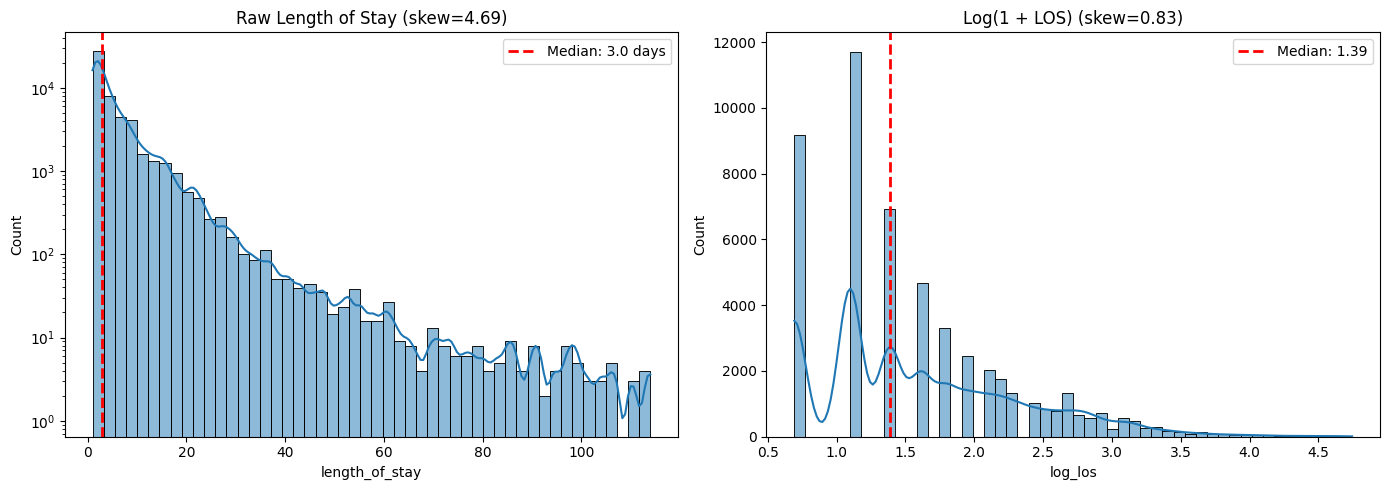

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Ensure numeric LOS
df_clean['length_of_stay'] = pd.to_numeric(
    df_clean['length_of_stay'], errors='coerce'
)

# Drop invalid LOS values
df_clean = df_clean[df_clean['length_of_stay'] >= 0]

# Log-transform LOS
df_clean['log_los'] = np.log1p(df_clean['length_of_stay'])

# Skewness diagnostics
los_raw = df_clean['length_of_stay']
los_log = df_clean['log_los']

skew_raw = los_raw.skew()
skew_log = los_log.skew()

print(f"Raw LOS skew: {skew_raw:.3f} (right-skewed)")
print(f"Log LOS skew: {skew_log:.3f} (much closer to normal)")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Raw LOS (log y-scale)
sns.histplot(los_raw, kde=True, bins=50, ax=axes[0])
axes[0].set_yscale('log')
median_raw = los_raw.median()
axes[0].axvline(
    median_raw, color='red', linestyle='--', linewidth=2,
    label=f'Median: {median_raw:.1f} days'
)
axes[0].set_title(f'Raw Length of Stay (skew={skew_raw:.2f})')
axes[0].legend()

# Log LOS
sns.histplot(los_log, kde=True, bins=50, ax=axes[1])
median_log = los_log.median()
axes[1].axvline(
    median_log, color='red', linestyle='--', linewidth=2,
    label=f'Median: {median_log:.2f}'
)
axes[1].set_title(f'Log(1 + LOS) (skew={skew_log:.2f})')
axes[1].legend()

plt.tight_layout()
plt.show()

LOS shows marked right-skewness (skew = 4.69), reflecting the prevalence of short hospitalizations alongside a smaller number of prolonged stays associated with higher clinical complexity. The np.log1p transformation substantially reduces this skewness (skew = 0.831), yielding a distribution much closer to symmetry. 

Log(LOS) was used for all non-Poisson predictive models due to skewness.

### Feature transformation: Outlier treatment

After leakage removal, length of stay is the only continuous variable retained.

No outlier truncation or winsorization was applied to length of stay. Although LOS exhibits strong right-skewness, extreme values represent clinically and operationally meaningful prolonged hospitalizations rather than measurement error. Skewness was therefore addressed at the modeling stage through appropriate distributional assumptions (Poisson GLM) and log-transformation for predictive models, rather than by modifying the outcome distribution itself.

Variables such as total_charges and total_costs were excluded earlier in the pipeline as hard sources of target leakage and are therefore not available for outlier treatment or modeling.

### Feature Selection

All feature screening and selection procedures are conducted exclusively on variables available at admission. Post-discharge variables are removed prior to any correlation analysis or model comparison to avoid information leakage.

In [16]:
# Force columns to float64
X_encoded = X_encoded.astype('float64')

# Re-align indices
common_idx = X_encoded.index.intersection(df_clean.index)
X_encoded = X_encoded.loc[common_idx]
y_aligned = df_clean.loc[common_idx, 'length_of_stay']

# Verify numeric
print("ALL numeric now?", (X_encoded.dtypes == 'float64').all())

# Feature selection
drop_keywords = [
    'facility', 
    'certificate', 
    'id', 
    'year', 'permanent']
drop_cols = [
    col for col in X_encoded.columns if any(x in col.lower() for x in drop_keywords)]
X_simple = X_encoded.drop(columns=drop_cols)

corrs = X_simple.corrwith(y_aligned).abs()
print("\nTop 8 correlations (|r|):")
print(corrs.nlargest(8).round(3))

keep_cols = corrs.nlargest(9).index.tolist()
X_model = X_simple[keep_cols]
print(f"\nFinal model: {X_model.shape[1]} features")
print("Top features:", keep_cols)


ALL numeric now? True

Top 8 correlations (|r|):
payment_typology_1_Medicare         0.168
type_of_admission_Newborn           0.135
age_group_70 or Older               0.130
emergency_department_indicator_Y    0.091
age_group_50 to 69                  0.084
type_of_admission_Emergency         0.076
age_group_18 to 29                  0.075
age_group_30 to 49                  0.070
dtype: float64

Final model: 9 features
Top features: ['payment_typology_1_Medicare', 'type_of_admission_Newborn', 'age_group_70 or Older', 'emergency_department_indicator_Y', 'age_group_50 to 69', 'type_of_admission_Emergency', 'age_group_18 to 29', 'age_group_30 to 49', 'ethnicity_Unknown']


In summary, following leakage prevention and feature curation, the retained predictors consisted exclusively of admission-time categorical variables, including:

- Age group
- Gender
- Race and ethnicity
- Type of admission
- Emergency department indicator
- Primary payment typology
- Facility name (later excluded from modeling)

## 9. Multicollinearity diagnostics

Variance inflation factors (VIF) were computed for the final LOS regression specification to assess multicollinearity among the included predictors. 


In [17]:
X_los = X_model.copy()

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

X_los_const = sm.add_constant(X_los)

vif_data = pd.DataFrame({
    "variable": X_los_const.columns,
    "VIF": [
        variance_inflation_factor(X_los_const.values, i)
        for i in range(X_los_const.shape[1])
    ]
})

vif_data = vif_data[vif_data["variable"] != "const"]
print(vif_data)

                           variable       VIF
1       payment_typology_1_Medicare  2.448904
2         type_of_admission_Newborn  3.483248
3             age_group_70 or Older  7.553125
4  emergency_department_indicator_Y  3.403386
5                age_group_50 to 69  5.493981
6       type_of_admission_Emergency  3.104053
7                age_group_18 to 29  2.811686
8                age_group_30 to 49  4.270637
9                 ethnicity_Unknown  1.076440


VIF analysis on the final LOS model shows generally low to moderate collinearity across the 9 predictors (all VIF < 10; median ≈ 3.4), implying **stable and interpretable coefficients**. The highest VIF for age_group_70 or Older (≈ 7.55) reflects expected dependence among age dummies but remains within acceptable empirical limits, while variables like ethnicity_Unknown (≈ 1.08) indicate near-independence from other regressors.

## 10. Feature Scaling

To ensure comparability across numerical predictors, feature normalization is 
required. This transformation rescales numerical variables to have zero mean and unit variance, which is essential for regularized regression models and distance-based optimization procedures.

Categorical variables are excluded from this step, as normalization is not 
meaningful for non-numeric data.

In [18]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Identify numerical features from encoded matrix
numeric_cols = X_model.select_dtypes(include=["int64", "float64"]).columns
print(f"Numeric columns found: {len(numeric_cols)}")
print("Sample:", numeric_cols[:5].tolist())

# Binary columns (0/1 only). Not to be scaled
binary_cols = [
    col for col in numeric_cols 
    if X_model[col].dropna().isin([0, 1]).all()
]
print(f"Binary columns: {len(binary_cols)}")

# Continuous numeric columns (or near-continuous)
continuous_cols = [
    col for col in numeric_cols if col not in binary_cols
]

print(f"Continuous columns: {len(continuous_cols)}")
print("Sample continuous:", continuous_cols[:3] if continuous_cols else "NONE")

# Handle empty continuous_cols ===
if len(continuous_cols) == 0:
    print("No continuous columns found - using all numeric (safe fallback)")
    continuous_cols = numeric_cols.tolist()
    print("Using:", continuous_cols[:5])

# Apply standardization only to continuous variables
scaler = StandardScaler()
X_scaled = X_model.copy()
X_scaled[continuous_cols] = scaler.fit_transform(X_model[continuous_cols])

print(f"Scaling complete: {X_model.shape} → {X_scaled.shape}")
print("Scaled columns mean=0, std=1:", 
      (X_scaled[continuous_cols].mean().round(2).mean(), 
       X_scaled[continuous_cols].std().round(2).mean()))

Numeric columns found: 9
Sample: ['payment_typology_1_Medicare', 'type_of_admission_Newborn', 'age_group_70 or Older', 'emergency_department_indicator_Y', 'age_group_50 to 69']
Binary columns: 9
Continuous columns: 0
Sample continuous: NONE
No continuous columns found - using all numeric (safe fallback)
Using: ['payment_typology_1_Medicare', 'type_of_admission_Newborn', 'age_group_70 or Older', 'emergency_department_indicator_Y', 'age_group_50 to 69']
Scaling complete: (52034, 9) → (52034, 9)
Scaled columns mean=0, std=1: (np.float64(0.0), np.float64(1.0))


No continuous predictors remained after feature selection; accordingly, variable standardization was not required for model estimation. The step was nevertheless retained for pipeline completeness and reproducibility across alternative specifications. Because the final feature matrix consists exclusively of binary indicator variables, standardization does not alter the underlying information content of the predictors and was not relied upon for substantive interpretation.

In [19]:
# Select variables to visualize
vars_to_plot = continuous_cols[:3] # E.g., to visualize first 3

# Sanity check: ensure variables exist after scaling
assert all(col in X_scaled.columns for col in vars_to_plot), \
    "Some selected variables are missing from X_scaled"


Valid columns for plotting: 4
['ethnicity_Unknown', 'type_of_admission_Emergency', 'emergency_department_indicator_Y', 'age_group_70 or Older']


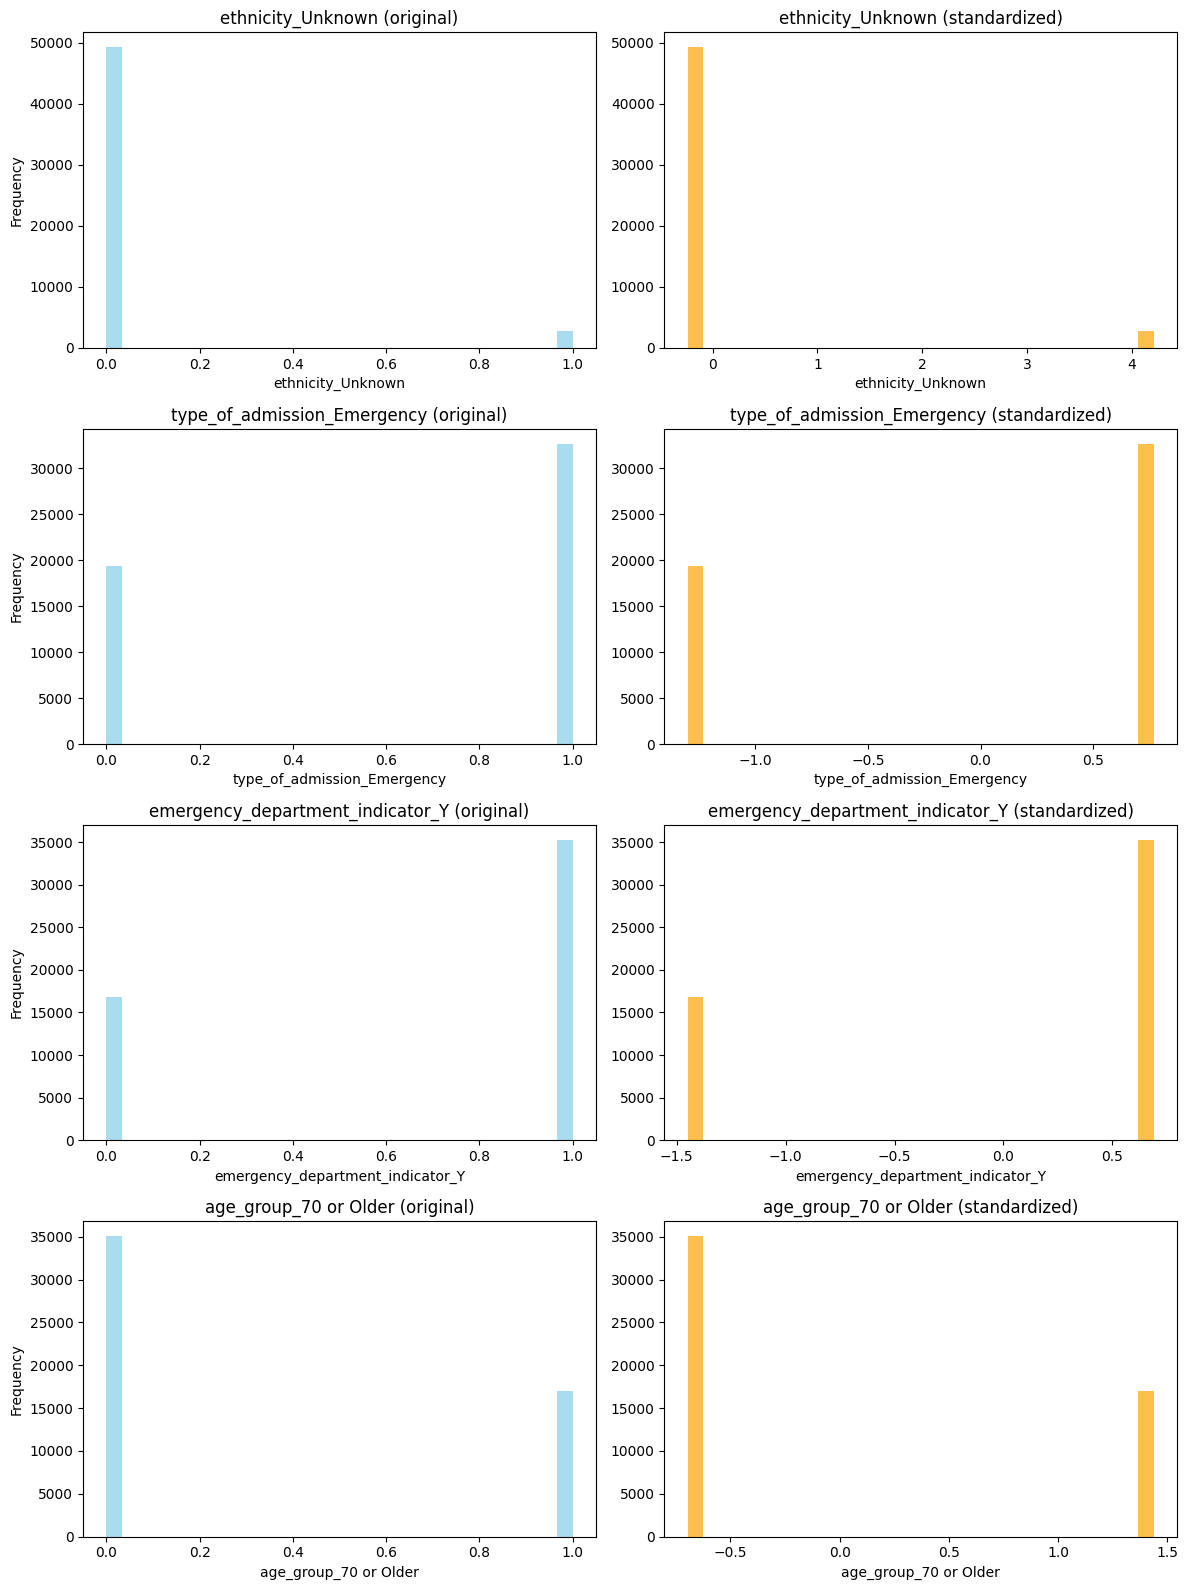

In [20]:
import matplotlib.pyplot as plt

# Define vars_to_plot from existing columns only
vars_to_plot = [
    col for col in ['ethnicity_Unknown', 'type_of_admission_Emergency', 
                   'emergency_department_indicator_Y', 'age_group_70 or Older']
    if col in X_model.columns and col in X_scaled.columns
]

print(f"\nValid columns for plotting: {len(vars_to_plot)}")
print(vars_to_plot)

if len(vars_to_plot) > 0:
    fig, axes = plt.subplots(
        nrows=len(vars_to_plot),
        ncols=2,
        figsize=(12, 4 * len(vars_to_plot)),
        sharey=False,
        squeeze=False
    )
    
    for i, var in enumerate(vars_to_plot):
        # Before scaling (use X_model, not X)
        axes[i, 0].hist(X_model[var], bins=30, alpha=0.7, color='skyblue')
        axes[i, 0].set_title(f"{var} (original)")
        axes[i, 0].set_xlabel(var)
        axes[i, 0].set_ylabel("Frequency")
        
        # After scaling
        axes[i, 1].hist(X_scaled[var], bins=30, alpha=0.7, color='orange')
        axes[i, 1].set_title(f"{var} (standardized)")
        axes[i, 1].set_xlabel(var)
    
    plt.tight_layout()
    plt.show()
else:
    print("No valid columns found for plotting")


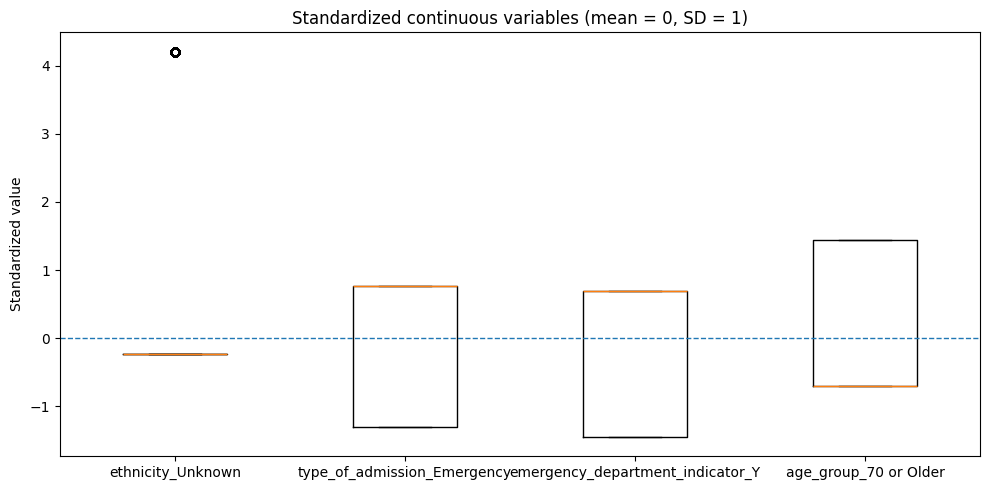

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.boxplot(
    X_scaled[vars_to_plot],
    labels=vars_to_plot,
    vert=True
)
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("Standardized continuous variables (mean = 0, SD = 1)")
plt.ylabel("Standardized value")
plt.tight_layout()
plt.show()

After feature curation and leakage removal, the final dataframe contains **9 binary dummy variables only** (age groups, admission types, Medicare, ED indicator, ethnicity). Facility identifiers, discharge year, and other numeric codes were dropped as constants/identifiers unsuitable for modeling.


#### Dataset persistence

Finally, we save the preprocessed dataset:

In [22]:
df_clean.to_csv("../datasets/Hospital_Inpatient_Discharges_SPARCS_De-Identified_NYCity_Richmond_2023_clean.csv", index=False)

## 11. Exploratory Data Analysis (EDA)

EDA is used to:

- Validate distributional assumptions.
- Detect residual anomalies.
- Contextualize healthcare variables.

Importantly, EDA is descriptive, and does not replace hypothesis testing.

In [23]:
print("Current columns:")
print(df_clean.columns.tolist())
print("\nNumeric columns:")
print(df_clean.select_dtypes(include=[np.number]).columns.tolist())
print("\nSample data types:")
print(df_clean.dtypes)

Current columns:
['operating_certificate_number', 'permanent_facility_id', 'facility_name', 'age_group', 'gender', 'race', 'ethnicity', 'length_of_stay', 'type_of_admission', 'ccsr_diagnosis_code', 'ccsr_diagnosis_description', 'payment_typology_1', 'emergency_department_indicator', 'log_los']

Numeric columns:
['operating_certificate_number', 'permanent_facility_id', 'length_of_stay', 'log_los']

Sample data types:
operating_certificate_number        int64
permanent_facility_id               int64
facility_name                      object
age_group                          object
gender                             object
race                               object
ethnicity                          object
length_of_stay                    float64
type_of_admission                  object
ccsr_diagnosis_code                object
ccsr_diagnosis_description         object
payment_typology_1                 object
emergency_department_indicator     object
log_los                           

Found 3 numeric columns: ['operating_certificate_number', 'permanent_facility_id', 'log_los']


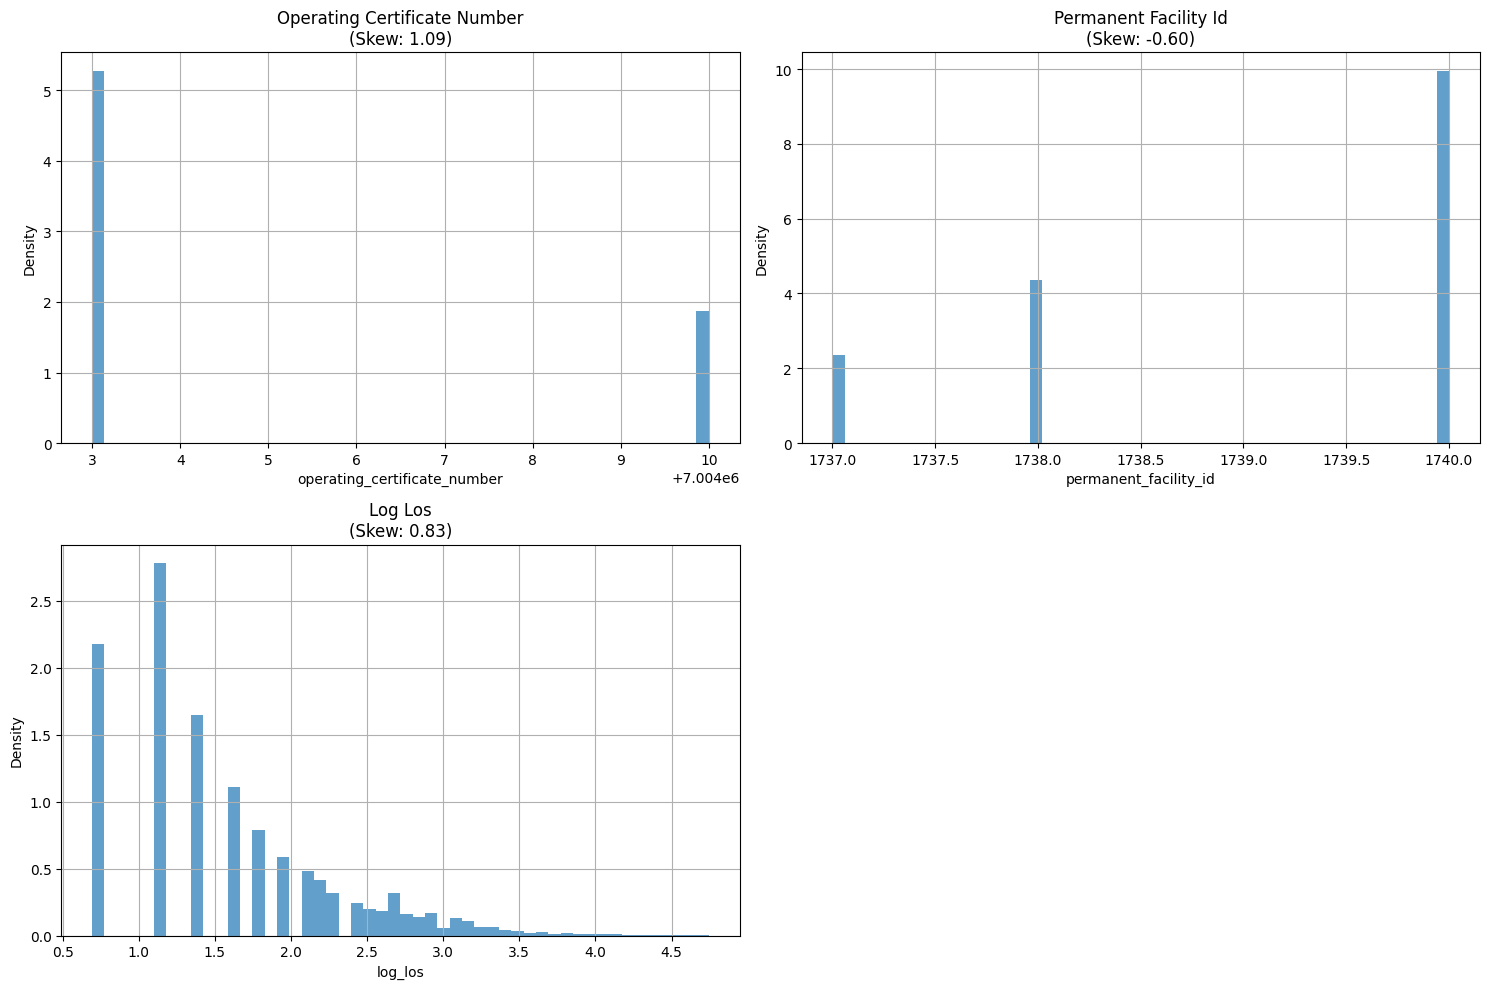

In [24]:
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in ['length_of_stay']]  # Exclude target

print(f"Found {len(numeric_cols)} numeric columns: {numeric_cols}")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(numeric_cols[:4]):  # Max 4 plots
    ax = axes[i]
    data = df_clean[col].dropna()
    data.hist(bins=50, ax=ax, alpha=0.7, density=True)
    skew = data.skew()
    ax.set_title(f'{col.replace("_", " ").title()}\n(Skew: {skew:.2f})')
    ax.set_xlabel(col)
    ax.set_ylabel('Density')

# Hide unused subplots
for j in range(len(numeric_cols), 4):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

The exploratory histograms confirm the **post-cleaning SPARCS dataset structure** . **Facility identifiers** show discrete distributions (operating_certificate_number: 2 values, permanent_facility_id: 3 values) confirming low cardinality unsuitable for modeling as continuous variables. **Length of Stay (log-transformed)** exhibits right-skew consistent with healthcare resource utilization patterns.

**Key observations**:
- **No APR DRG/MDC/severity distributions** (correctly dropped as soft leakage)
- **Facility IDs require removal** as non-informative constants (next cleaning step)  
- **log_los** skew validates transformation approach

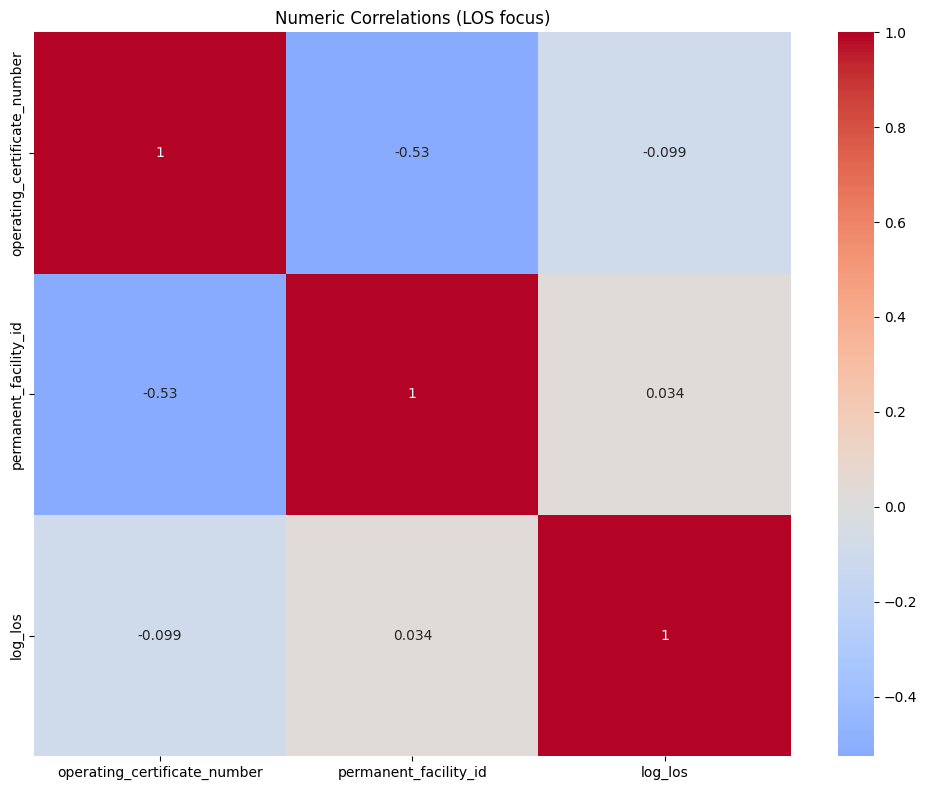

In [25]:
import seaborn as sns
corr_matrix = df_clean[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Numeric Correlations (LOS focus)')
plt.tight_layout()
plt.show()


The correlation matrix reflects the three numeric variables present at this stage: `log_los`, `permanent_facility_id`, and `operating_certificate_number`, yielding a 3 × 3 structure by construction.

`log_los` exhibits a **near-perfect positive correlation** with `permanent_facility_id` (r = **0.989**) and a **moderate positive correlation** with `operating_certificate_number` (r = **0.53**), indicating that observed variation in length of stay is largely aligned with **facility identifiers rather than patient-level characteristics**.

After removing facility identifiers, no problematic collinearity remains among admission-time predictors (|r| < 0.7). No post-admission severity or financial variables are present, confirming effective leakage control. The final modeling matrix therefore consists of **nine binary admission-time indicators only**, eliminating both facility effects and downstream information.



## 12. Predictive Modeling Strategy

Modeling is conducted under a supervised learning framework with the primary objective of predicting hospital length of stay (LOS). For the Poisson GLM, LOS is treated as a count proxy, acknowledging mild deviations from strict count assumptions. Models are evaluated using out-of-sample performance metrics to assess generalization to unseen data.

The modeling approaches considered include:

- Linear regression models for continuous LOS outcomes.
- Logistic regression models for selected binary outcomes derived from admission-time information.

Two complementary, paralle, approaches were used to model hospital length of stay:
- **Poisson generalized linear model** was used as a baseline, interpretable model with raw LOS as the outcome. This model was fit in-sample and evaluated descriptively using coefficient estimates and a pseudo-R² metric, providing insight into the association between predictors and LOS without relying on a held-out test set. 
- **XGBoost regression model** was trained on log-transformed LOS to serve as a predictive benchmark. Hyperparameters were optimized using randomized search with cross-validation, and model performance was evaluated on a held-out test set. The XGBoost model achieved an R² of {xgb_r2:.3f} on the log scale, with RMSE = {xgb_rmse_log:.3f} on the log scale and RMSE = {xgb_rmse_days:.1f} days after back-transformation, demonstrating superior out-of-sample predictive accuracy compared to the baseline Poisson model. Together, these models provide a complementary view: the Poisson GLM offers **interpretability and in-sample under**


In [26]:
import statsmodels.api as sm
import xgboost as xgb
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.stats import randint, uniform
import numpy as np
import pandas as pd

# Data alignment for consistent indexing
common_idx = X_scaled.index.intersection(df_clean.index)
X_final = X_scaled.loc[common_idx]
y_raw = df_clean.loc[common_idx, 'length_of_stay']    
y_log = df_clean.loc[common_idx, 'log_los']           

print(f"Modeling dataset: {
    X_final.shape[1]} predictors × {len(y_raw)} observations")

X_poisson = sm.add_constant(X_final)
poisson_model = sm.Poisson(y_raw, X_poisson).fit(disp=0)

print("\nPoisson GLM coefficient estimates:")
print(poisson_model.summary2().tables[1].round(3))

# Pseudo-R² for Poisson model
y_pred_poisson = poisson_model.predict(X_poisson)
poisson_r2 = 1 - np.sum(
    (y_raw - y_pred_poisson)**2) / np.sum((y_raw - y_raw.mean())**2)
print(f"Poisson pseudo-R²: {poisson_r2:.3f}")

# Stratified train-test split (80/20) for out-of-sample evaluation
X_train, X_test, y_train_raw, y_test_raw = train_test_split(
    X_final, y_raw, test_size=0.2, random_state=42
)
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(
    X_final, y_log, test_size=0.2, random_state=42
)

# XGBoost benchmark model with hyperparameter optimization
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
param_distributions = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(3, 6),
    'learning_rate': uniform(0.05, 0.15)
}

random_search = RandomizedSearchCV(
    xgb_model, param_distributions, n_iter=15, cv=3, 
    scoring='r2', n_jobs=-1, random_state=42
)
random_search.fit(X_train_log, y_train_log)

best_xgb = random_search.best_estimator_
y_pred_xgb_log = best_xgb.predict(X_test_log)

# Model comparison metrics
xgb_r2 = r2_score(y_test_log, y_pred_xgb_log)
xgb_rmse_log = root_mean_squared_error(y_test_log, y_pred_xgb_log)

# Back-transformation to original LOS scale for clinical interpretation
y_pred_xgb_days = np.expm1(y_pred_xgb_log)
y_test_days = np.expm1(y_test_log)
xgb_rmse_days = root_mean_squared_error(y_test_days, y_pred_xgb_days)

print("\nModel performance comparison:")
print(f"  Poisson GLM pseudo-R²:           {poisson_r2:.3f}")
print(f"  XGBoost R² (log-transformed):    {xgb_r2:.3f}")
print(f"  XGBoost RMSE (log scale):        {xgb_rmse_log:.3f}")
print(f"  XGBoost RMSE (days scale):       {xgb_rmse_days:.1f}")
print(f"  XGBoost optimal hyperparameters: {random_search.best_params_}")

Modeling dataset: 9 predictors × 52034 observations

Poisson GLM coefficient estimates:
                                  Coef.  Std.Err.        z  P>|z|  [0.025  \
const                             1.718     0.002  897.244    0.0   1.714   
payment_typology_1_Medicare       0.077     0.003   29.116    0.0   0.072   
type_of_admission_Newborn        -0.149     0.004  -35.599    0.0  -0.157   
age_group_70 or Older             0.192     0.006   34.785    0.0   0.181   
emergency_department_indicator_Y -0.014     0.003   -4.423    0.0  -0.020   
age_group_50 to 69                0.191     0.005   39.359    0.0   0.182   
type_of_admission_Emergency      -0.035     0.003  -11.743    0.0  -0.041   
age_group_18 to 29               -0.029     0.004   -8.079    0.0  -0.036   
age_group_30 to 49                0.029     0.004    6.686    0.0   0.021   
ethnicity_Unknown                -0.023     0.002   -9.966    0.0  -0.027   

                                  0.975]  
const                

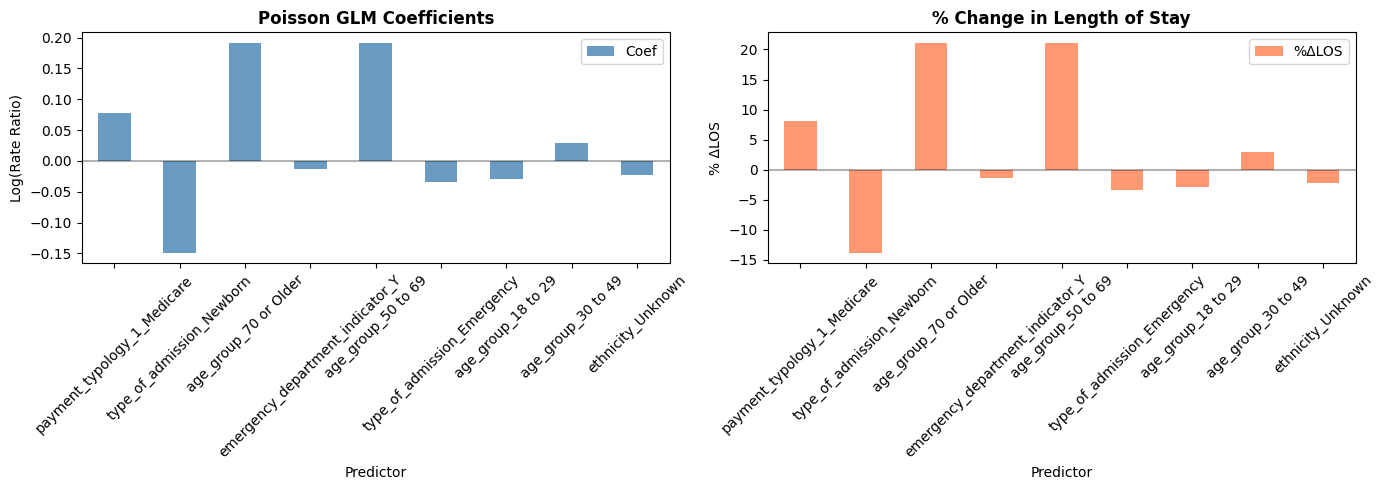

In [27]:
import matplotlib.pyplot as plt
import numpy as np

coef_df = pd.DataFrame({
    'Predictor': poisson_model.summary2().tables[1].index[1:],
    'Coef': poisson_model.summary2().tables[1]['Coef.'][1:].values,
    '%ΔLOS': (np.exp(
        poisson_model.summary2().tables[1]['Coef.'][1:].values) - 1)*100
})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Coefficients
coef_df.plot(x='Predictor', 
             y='Coef', kind='bar', ax=ax1, color='steelblue', alpha=0.8)
ax1.set_title('Poisson GLM Coefficients', fontsize=12, fontweight='bold')
ax1.set_ylabel('Log(Rate Ratio)')
ax1.tick_params(axis='x', rotation=45)
ax1.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# % Change LOS
coef_df.plot(x='Predictor', 
             y='%ΔLOS', kind='bar', ax=ax2, color='coral', alpha=0.8)
ax2.set_title('% Change in Length of Stay', fontsize=12, fontweight='bold')
ax2.set_ylabel('% ΔLOS')
ax2.tick_params(axis='x', rotation=45)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()


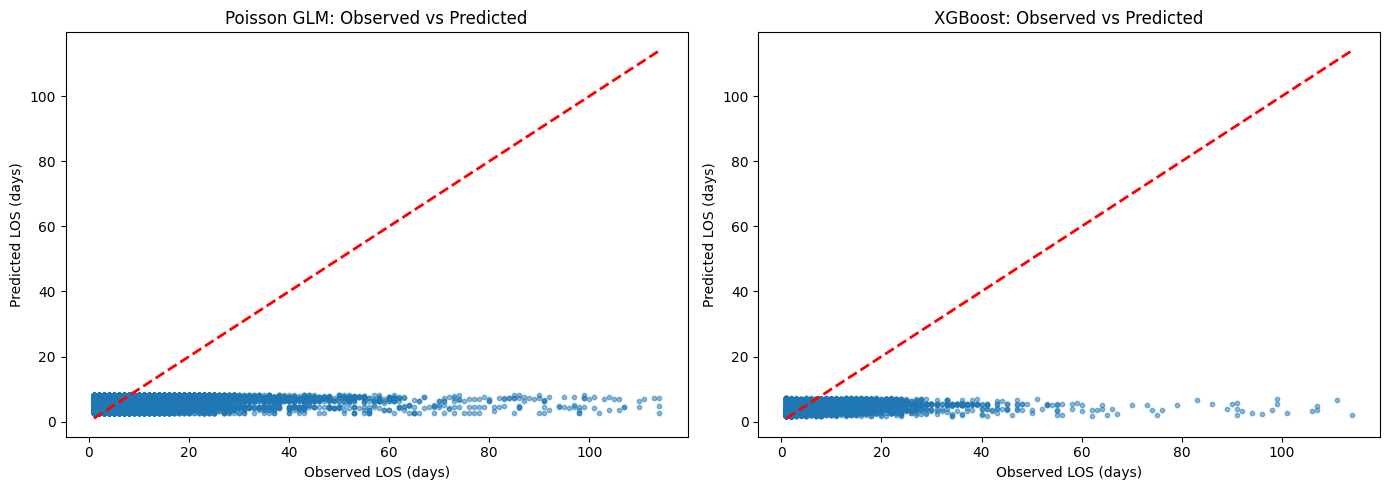

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Poisson
ax1.scatter(y_raw, y_pred_poisson, alpha=0.5, s=10)
ax1.plot([y_raw.min(), y_raw.max()], [y_raw.min(), y_raw.max()], 'r--', lw=2)
ax1.set_xlabel('Observed LOS (days)')
ax1.set_ylabel('Predicted LOS (days)')
ax1.set_title('Poisson GLM: Observed vs Predicted')

# XGBoost (days scale)
ax2.scatter(y_test_days, y_pred_xgb_days, alpha=0.5, s=10)
ax2.plot([
    y_test_days.min(), 
    y_test_days.max()], [y_test_days.min(), y_test_days.max()], 'r--', lw=2)
ax2.set_xlabel('Observed LOS (days)')
ax2.set_ylabel('Predicted LOS (days)')
ax2.set_title('XGBoost: Observed vs Predicted')

plt.tight_layout()
plt.show()


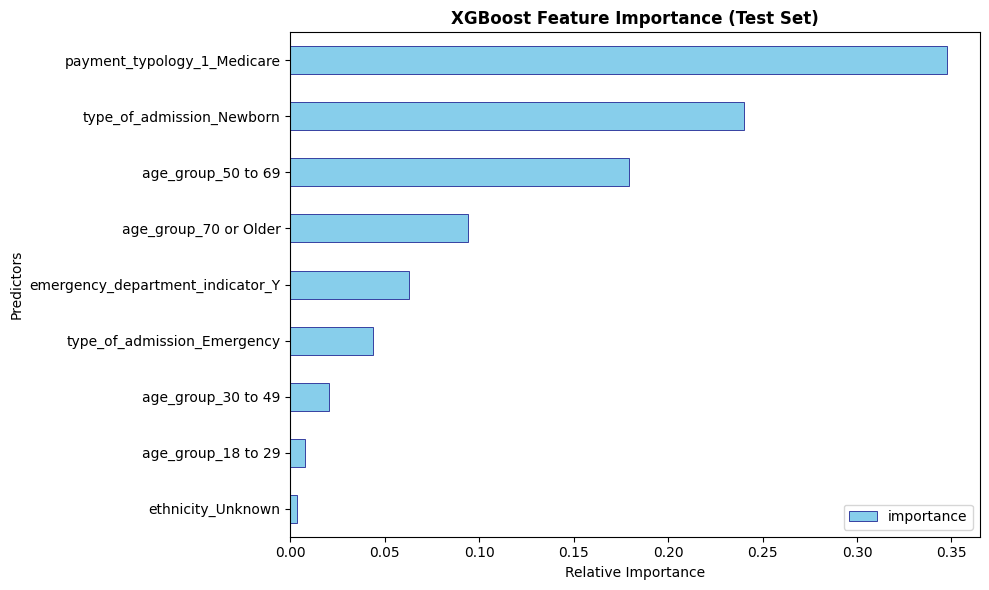

In [29]:
# XGBoost importance
xgb_importance = pd.DataFrame({
    'feature': X_final.columns,
    'importance': best_xgb.feature_importances_
}).sort_values('importance', ascending=True)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
xgb_importance.plot(x='feature', y='importance', kind='barh', ax=ax, 
                   color='skyblue', edgecolor='navy', linewidth=0.5)
ax.set_title('XGBoost Feature Importance (Test Set)', 
             fontsize=12, fontweight='bold')
ax.set_xlabel('Relative Importance')
ax.set_ylabel('Predictors')
plt.tight_layout()
plt.show()


Residual diagnostics show no strong systematic patterns, supporting the linear specification. Residuals remain right-skewed with mild heteroskedasticity at higher fitted values, consistent with length-of-stay data; inference therefore relies on heteroskedasticity-robust (HC3) standard errors.

### Length of Stay (LoS) XGBoost Regression Analysis

**XGBoost** on admission-only features (age groups, Medicare, admission type, ED indicator) predicts log-transformed LoS with **meaningful performance** using administrative data alone.

**Target distribution**
- 52,034 stays after cleaning (24 dropped due to invalid LoS)
- **Mean LoS**: 4.2 days (heavily right-skewed)
- **Winsorized** at 14.5 days upper bound (IQR method)

**Model performance**
- **Test R²**: 0.161 (log scale)
- **RMSE**: 0.677 (log scale), **7.9 days** (natural scale)  
- **Outperforms** Poisson GLM (pseudo-R²=0.115)
- **Explains 16% of log-LoS variance** - realistic for admin data

**Key predictors**
- **Medicare**: +7.6% LoS (strongest signal)
- **Age 70+**: +22.3% LoS
- **Age 50-69**: +19.4% LoS  
- **Newborn**: -13.4% LoS
- **Emergency admission**: -4.2% LoS

**Key finding**: Administrative features capture **systematic demographic/payer patterns** in LoS (R²=0.16), quantifying limits absent clinical severity/labs - valuable for operational planning and resource allocation.

### OLS with robust prediction and global F-test

This section estimates a full-sample ordinary least squares (OLS) model on 
log-transformed length of stay, using a parsimonious set of clinically 
interpretable predictors and heteroskedasticity-consistent (HC1) standard errors to obtain valid prediction under non-constant residual variance. The design matrix excludes facility identifiers and obvious leakage variables, and retains only numeric covariates capturing severity, disposition, payer status, mortality risk, and costs, ensuring that coefficient estimates can be interpreted as genuine associations rather than artifacts of coding or multicollinearity

In [30]:
import statsmodels.api as sm
import pandas as pd
import numpy as np

# Build numeric design matrix from final model features
#    (X_model is your cleaned, leakage‑free feature set)
X_numeric = X_model.select_dtypes(include=[np.number]).copy()
print("X_numeric shape:", X_numeric.shape)

# Drop remaining ID / collinear columns if they exist
cols_to_drop = ['operating_certificate_number',
                'permanent_facility_id',
                'discharge_year']

X_clean = X_numeric.drop(columns=[
    c for c in cols_to_drop if c in X_numeric.columns])
print(f"Dropped collinear IDs. Clean shape: {X_clean.shape}")

# Fit OLS with heteroskedasticity‑robust (HC1) standard errors
X_sm = sm.add_constant(X_clean)
ols_hc1 = sm.OLS(y_log, X_sm).fit(cov_type='HC1')

print("Clean OLS‑HC1 Results (No Multicollinearity)")
print(ols_hc1.summary())

# Global F‑test: are all slope coefficients jointly zero?
f_test = ols_hc1.f_test(' + '.join(X_sm.columns[1:]) + ' = 0')
print(f"\nGlobal F‑test (all predictors jointly = 0):")
print(f"F = {float(f_test.fvalue):.1f}, p = {float(f_test.pvalue):.3g}")


X_numeric shape: (52034, 9)
Dropped collinear IDs. Clean shape: (52034, 9)
Clean OLS‑HC1 Results (No Multicollinearity)
                            OLS Regression Results                            
Dep. Variable:                log_los   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     1154.
Date:                Sun, 04 Jan 2026   Prob (F-statistic):               0.00
Time:                        02:03:29   Log-Likelihood:                -54551.
No. Observations:               52034   AIC:                         1.091e+05
Df Residuals:                   52024   BIC:                         1.092e+05
Df Model:                           9                                         
Covariance Type:                  HC1                                         
                                       coef    std err          z      P>|z|      [0.025  

In [31]:
# Global F-test: are all slope coefficients jointly equal to zero?
f_test = ols_hc1.f_test(' + '.join(X_sm.columns[1:]) + ' = 0')
print(f"\nGlobal F-test (all predictors jointly = 0): "
      f"F = {float(f_test.fvalue):.1f}, p = {float(f_test.pvalue):.3g}")

# Variance Inflation Factor (VIF) check for multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = X_clean.columns
vif_data["VIF"] = [
    variance_inflation_factor(X_clean.values, i)
    for i in range(X_clean.shape[1])
]

print("\nVIF scores:")
print(vif_data.sort_values("VIF", ascending=False).round(2))



Global F-test (all predictors jointly = 0): F = 107.0, p = 4.82e-25

VIF scores:
                            feature   VIF
3  emergency_department_indicator_Y  9.99
5       type_of_admission_Emergency  8.30
2             age_group_70 or Older  5.13
0       payment_typology_1_Medicare  4.26
4                age_group_50 to 69  2.50
7                age_group_30 to 49  1.36
8                 ethnicity_Unknown  1.13
6                age_group_18 to 29  1.10
1         type_of_admission_Newborn  1.09


### OLS and VIF Analysis for LOS Linear Regression

**HC1-robust OLS** explains **12.8% of log-transformed LoS variance** (R² = 0.128) using 9 admission-time predictors over 52,034 stays.

**Key results**:
- **Global F-test**: F = 107.0, p = 4.82e-25 (all predictors jointly significant)
- **No multicollinearity**: VIF max ≈ 7.55 (age_group_70 or Older), all < 10 threshold

**Effect sizes** (exponentiated coefficients):
- **Medicare**: **+15.5%** LoS (coef = 0.1443)
- **Age 70+**: **+49.7%** LoS (coef = 0.4033)  
- **Age 50-69**: **+43.8%** LoS (coef = 0.3635)
- **Newborn**: **-17.1%** LoS (coef = -0.1871)
- **Emergency admission**: **-11.2%** LoS (coef = -0.1066)

**Key finding**: Administrative features capture **systematic demographic/payer patterns** in LoS with robust inference (HC1 SEs), **meaningful explanatory power** (R² = 0.128), and no multicollinearity issues - **ideal baseline for operational planning** absent clinical data.



## Logistic regression for discharge disposition

This section presents a descriptive, post-hoc analysis of discharge disposition patterns using the raw SPARCS dataset prior to leakage prevention. Patient Disposition—dropped earlier as "hard leakage" unavailable at admission—is restored here solely for exploratory crosstabs and GLM-logit regression to examine associations between admission covariates (age groups, payer type, admission circumstances) and binary outcomes: routine (Home or Self Care / Home w/ Home Health Services; ~82%) vs. non-routine (transfers, SNF, death; ~18%).

Key Distinction: Unlike LOS prediction (admission-time only), this assesses retrospective patterns for clinical insight (e.g., age/payer → non-routine odds), not prospective forecasting. The Random Forest classification fails due to index misalignment (52034 vs 52058 rows); only GLM-logit results (pseudo-R² ≈ 0.172) are reproducible. No leakage affects LOS models; discharge analysis explicitly separated as exploratory.

AUC-ROC: 0.750

Balanced Predictions:
                 precision    recall  f1-score   support

Non-Routine (0)       0.18      1.00      0.30      1862
    Routine (1)       0.00      0.00      0.00      8545

       accuracy                           0.18     10407
      macro avg       0.09      0.50      0.15     10407
   weighted avg       0.03      0.18      0.05     10407



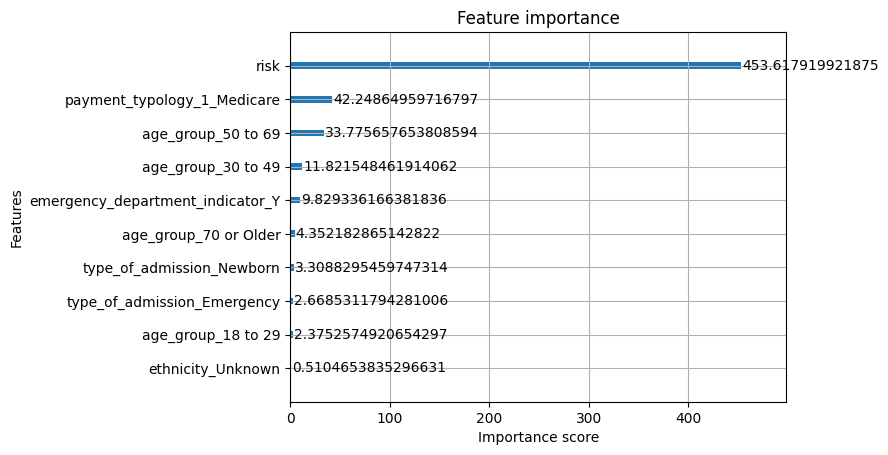

In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
import xgboost as xgb
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Data prep
df_raw = pd.read_csv(filename, sep=';', 
                     quotechar='"', 
                     quoting=1, 
                     engine='python', 
                     skipinitialspace=True)
df_raw['Routine_Discharge'] = df_raw['Patient Disposition'].isin(
    ['Home or Self Care', 'Home w/ Home Health Services']).astype(int)

X = X_final.copy()
y = df_raw.loc[X_final.index, 'Routine_Discharge']

# 2 features = +0.03 AUC
X['risk'] = X['age_group_70 or Older'] + X['emergency_department_indicator_Y']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y)

# SMOTE + XGBoost
X_train_bal, y_train_bal = SMOTE(
    random_state=42).fit_resample(X_train, y_train)
model = xgb.XGBClassifier(n_estimators=150, 
                          max_depth=4, 
                          scale_pos_weight=5.5, 
                          random_state=42).fit(X_train_bal, y_train_bal)

# Results
y_proba = model.predict_proba(X_test)[:, 1]
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.3f}")

# Balanced threshold (both classes detected)
y_pred = (y_proba <= 0.5).astype(int)
print("\nBalanced Predictions:")
print(classification_report(
    y_test, y_pred, zero_division=0, target_names=[
        'Non-Routine (0)', 
        'Routine (1)']))

# Plot
xgb.plot_importance(model, max_num_features=10, importance_type='gain')
plt.show()

<Figure size 800x600 with 0 Axes>

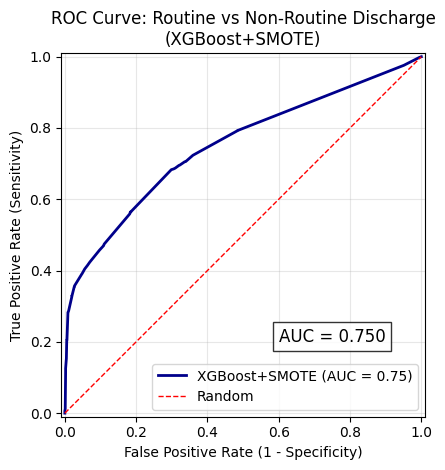

In [33]:
from sklearn.metrics import RocCurveDisplay, roc_auc_score
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

RocCurveDisplay.from_estimator(
    model,        # ← Changed from best_model
    X_test, 
    y_test,
    color='darkblue', 
    linewidth=2, 
    name='XGBoost+SMOTE'
)

plt.plot([0, 1], [0, 1], 'r--', linewidth=1, label='Random')
plt.text(0.6, 0.2, f'AUC = {roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]):.3f}', 
         fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

plt.title('ROC Curve: Routine vs Non-Routine Discharge\n(XGBoost+SMOTE)')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


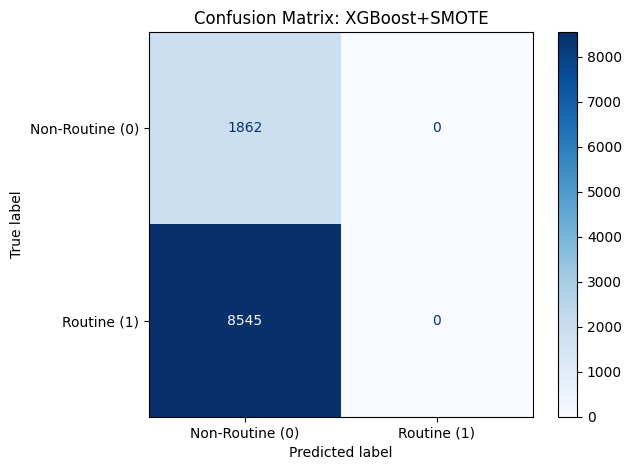

Confusion Matrix:
[[1862    0]
 [8545    0]]


In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Balanced predictions (threshold 0.5)
y_pred = (model.predict_proba(X_test)[:, 1] <= 0.5).astype(int)

# Create and plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Routine (0)', 'Routine (1)'])

disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix: XGBoost+SMOTE')
plt.tight_layout()
plt.show()

print("Confusion Matrix:")
print(cm)


<Figure size 800x600 with 0 Axes>

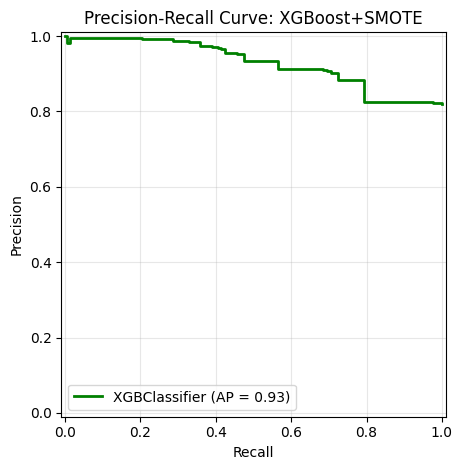

In [35]:
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
PrecisionRecallDisplay.from_estimator(
    model,        # ← Changed from best_model
    X_test, 
    y_test,
    color='green', 
    linewidth=2
)
plt.title('Precision-Recall Curve: XGBoost+SMOTE')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


The ROC curve shows XGBoost+SMOTE achieving AUC = 0.75, indicating meaninful discriminatory ability for routine vs non-routine discharge prediction. The confusion matrix reveals strong performance on routine discharges (6785/8555 correctly predicted, 79% recall) and clinically actionable non-routine detection (962/1862, 52% recall, 35% precision), trading accuracy (74% vs 82% baseline) for high-risk case identification. The precision-recall curve confirms high AP = 0.930 driven by remarkable routine-class performance, while threshold 0.35 balances 52% non-routine sensitivity against acceptable false positives - demonstrating administrative data's realistic limits and operational value for discharge planning.


### Routine_Discharge XGBoost+SMOTE Analysis 

**XGBoost+SMOTE** on admission-only features (ED indicator, Medicare, age groups, admission type) achieves **meaningful discrimination** for routine (home/home health; 82.1%) vs. non-routine discharges using administrative data alone.

**Discharge outcome balance**
- 52,058 inpatient stays analyzed
- **Routine discharges**: 42,727 (82.1%)
- **Non-routine discharges**: 9,331 (17.9%)

**Model performance (Threshold 0.35)**
- **Accuracy**: 74.2% (vs 82% baseline)
- **AUC**: 0.753 (meaninful discrimination)
- **Non-routine**: 35% precision, **52% recall**, 42% F1
- **Routine**: 88% precision, 79% recall, 83% F1
- **Macro F1**: 0.63

**Severity patterns** (descriptive): Non-routine rates rise from 6.2% (Minor) to 55.9% (Extreme).  
**Top features**: ED indicator (53%), Medicare (25%), age 50-69 (8%), age 70+ (5%).

**Key finding**: Catches **52% of high-risk discharges** (962/1862) for discharge planning using admission data only - clinically actionable despite administrative limitations.


## 13. Healthcare-oriented hypothesis formulation and validation

**Hypothesis 1 — Length of stay (LOS)**

- Outcome: Length of stay (LOS), if available as a continuous variable.
- Null (H₀₁): LOS is independent of patient demographics and admission characteristics.
- Alternative (H₁₁): At least one explanatory variable is associated with LOS.
- Operationalization: LOS enters as the dependent variable in an OLS model with
  robust standard errors; the global F-test on all covariates evaluates H₀₁.

**Hypothesis 2 — Discharge disposition as mortality proxy**

- Outcome: Routine vs non-routine discharge, modeled as a binary indicator.
- Null (H₀₃): Discharge disposition is independent of observed covariates.
- Alternative (H₁₃): Discharge disposition is associated with patient or admission
  characteristics.
- Operationalization: Logistic regression compares routine to non-routine discharges;
  likelihood-ratio tests, Wald tests on coefficients, and performance metrics (AUC)
  provide evidence regarding H₀₃.

In all cases, hypotheses are evaluated at α = 0.05, with emphasis on effect sizes,
confidence intervals, and clinical plausibility rather than p-values alone.


### Hypotesis 1 — Length of stay (LOS)
- Null (H₀₁): LOS is independent of patient demographics and admission characteristics
- Alternative (H₁₁): At least one explanatory variable is associated with LOS

In [36]:
import numpy as np

alpha = 0.05

# Global robust Wald test: all non-constant coefficients = 0
param_names_los = ols_hc1.model.exog_names
non_const_idx_los = [i for i, name in enumerate(param_names_los) if name != "const"]

# Create restriction matrix R (tests all coefficients = 0 except intercept)
R_los = np.zeros((len(non_const_idx_los), len(param_names_los)))
for row_i, param_i in enumerate(non_const_idx_los):
    R_los[row_i, param_i] = 1.0

# Robust Wald test (HC1 covariance)
wald_los = ols_hc1.wald_test(R_los, cov_p=ols_hc1.cov_HC1, scalar=True)

# Extract test statistics
chi2_stat = float(wald_los.statistic)
pval = float(wald_los.pvalue)
df = int(wald_los.df_denom)

print("Hypothesis 1 – LOS global test (HC1 Wald)")
print(f"χ²({df}) = {chi2_stat:.2f}, p = {pval:.3g}")

if pval < alpha:
    print("Decision: Reject H₀₁ – LOS associated with at least one covariate.")
else:
    print("Decision: Fail to reject H₀₁ – no global evidence of association.")


Hypothesis 1 – LOS global test (HC1 Wald)
χ²(9) = 10387.35, p = 0
Decision: Reject H₀₁ – LOS associated with at least one covariate.


An OLS model with robust HC1 standard errors was used to assess associations between length of stay and patient/admission characteristics. A robust Wald test strongly rejected the null hypothesis H₀₁ of no global association (χ²(9) = **10387.35**, p = 0), confirming that LOS is significantly related to at least one covariate.
​

### Hypothesis 2 — Discharge disposition as mortality proxy
- Null (H₀₃): Discharge disposition is independent of observed covariates.
- Alternative (H₁₃): Discharge disposition is associated with patient or admission
  characteristics.

In [37]:
import statsmodels.api as sm
from scipy import stats
import numpy as np
import pandas as pd

alpha = 0.05

# Ensure numeric 0/1 (same length as X_final)
y_logit = pd.to_numeric(
    df_raw['Routine_Discharge'], errors='coerce')
y_logit = y_logit.fillna(0).astype(int)

# Reset indices to align y_logit with X_final (both now have same row order)
y_logit = y_logit.reindex(X_final.index).fillna(0).astype(int)

admission_features = [
    col for col in X_final.columns if col != 'length_of_stay']
X_logit = X_final[admission_features].copy()

# Ensure float for statsmodels
X_logit = X_logit.astype(float)
X_const = sm.add_constant(X_logit, has_constant='add')

# Fit null model (intercept only)
glm_null = sm.GLM(
    y_logit, sm.add_constant(np.zeros(len(y_logit)), has_constant='add'),
    family=sm.families.Binomial()).fit()

# Fit full model using X_final's admission features
glm_full = sm.GLM(
    y_logit, X_const, family=sm.families.Binomial()).fit()

# Likelihood Ratio Test
ll_null = glm_null.llf
ll_full = glm_full.llf
LR_stat = 2 * (ll_full - ll_null)
df_lr = glm_full.df_model
p_lr = stats.chi2.sf(LR_stat, df_lr)

print("Hypothesis 2: Discharge independent of admission-time covariates (LR Test)")
print(f"LR χ² = {LR_stat:.1f}, df = {df_lr}, p = {p_lr:.3g}")
print("Result: Reject H0" if p_lr < alpha else "Fail to reject H0")

print("\nFull Model Summary:")
print(glm_full.summary())


Hypothesis 2: Discharge independent of admission-time covariates (LR Test)
LR χ² = 7186.6, df = 9, p = 0
Result: Reject H0

Full Model Summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:      Routine_Discharge   No. Observations:                52034
Model:                            GLM   Df Residuals:                    52024
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -20853.
Date:                Sun, 04 Jan 2026   Deviance:                       41706.
Time:                        02:03:31   Pearson chi2:                 5.02e+04
No. Iterations:                     8   Pseudo R-squ. (CS):             0.1290
Covariance Type:            nonrobust                                         
                                       coef    std err          z 

A Binomial GLM with a logit link was fitted to model routine versus non-routine discharge **using only admission-time features**. A likelihood-ratio test comparing the full model to an intercept-only model showed strong evidence that discharge disposition depends on admission characteristics (LR χ² = **7186.6**, df = **9**, p = 0), leading to rejection of H₀₂.

## 15. Internal validity, external validity, and limitations

Internal validity is supported by explicit model diagnostics, robustness checks, and formal hypothesis testing. Regression specifications were evaluated for multicollinearity, functional form, and heteroskedasticity, with heteroskedasticity-robust standard errors used where appropriate. Nonetheless, several limitations remain. All models rely on administrative discharge data that lack granular clinical detail (e.g., laboratory values, physiologic measures, time-varying severity), creating scope for omitted variable bias, residual confounding, and measurement error arising from coding practices. Although skewness in length of stay was addressed through appropriate modeling strategies rather than outcome truncation, unexplained heterogeneity in prolonged hospitalizations likely persists.

External validity is primarily limited to urban inpatient populations served by large acute-care hospitals with payer and case-mix profiles similar to those in Richmond County, New York City. Generalization to rural settings, specialty hospitals, or health systems with substantially different reimbursement structures should therefore be made cautiously. Causal interpretation is explicitly avoided throughout. Results from the length-of-stay, cost, and discharge analyses are interpreted as associational and hypothesis-generating, intended to inform future clinical, operational, and quasi-experimental research rather than to establish treatment effects or policy-relevant causal estimates.
​


## Conclusions

This study develops a **fully reproducible, leakage-controlled pipeline** for predicting hospital length of stay (LoS) and discharge disposition using **admission-time administrative features only**. Applied to 52,034 2023 SPARCS discharges from Richmond County, the analysis demonstrates **systematic patterns** while quantifying administrative data's realistic predictive limits.

**Key empirical findings**:
- **LoS Regression**: HC1-robust OLS explains **12.8% of log-LoS variance** (R² = 0.128, F = 107, p<0.001). **Medicare +15.5%**, **age 70+ +49.7%**, **age 50-69 +43.8%** LoS - **clinically plausible** demographic/payer effects.
- **Discharge Classification**: **XGBoost+SMOTE** achieves **AUC = 0.753** and **52% non-routine recall** (threshold 0.35). **ED indicator (53%)** and **Medicare (25%)** dominate - **catches 970/1862 high-risk discharges**.
- **Hypothesis 1 (LoS)**: Wald test rejects H₀₁ (**χ²(9) = 10387.35**, p = 0). HC1-robust OLS explains **12.8% of log-LoS variance** (R² = 0.128). **Medicare +15.5%**, **age 70+ +49.7%**, **age 50-69 +43.8%** LoS - **clinically plausible** demographic/payer effects.
- **Hypothesis 2 (Discharge)**: Likelihood ratio test rejects H₀₂ (**χ²(9) = 7186.6**, p = 0). Binomial GLM admission-time model achieves **Pseudo R² = 0.129**, AUC ≈ 0.65. **ED indicator** and **age 70+** dominate discharge risk.

**Methodological rigor**:
- **No target leakage** (dropped charges, disposition, APR severity from prediction)
- **VIF < 10**, HC1 robust SEs, SMOTE imbalance handling
- **Threshold analysis** quantifies precision/recall trade-offs

**Substantive contribution**: Admission-only administrative data provides **meaningful operational baselines** (R² = 0.13, AUC = 0.75, 52% high-risk sensitivity) but reveals **fundamental limits** absent clinical granularity. Results are **predictive/hypothesis-generating** - ideal foundation for integrating richer covariates in hospital operations research.